### Imports

In [105]:
import numpy as np
import cv2
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

### Setup

#### Generate dataset as matrix from images

In [141]:
def generate_ds():
    arr = []
    labels = []
    for i in range(1,41):
        for j in range(1,11):
            path = 's' + str(i) + '/' + str(j) + '.pgm'
            labels.append(i)
            arr.append(cv2.imread(path,-1).flatten())
    return np.array(arr), np.array(labels)

#### Train test split

In [142]:
def train_test_split(matrix, labels):
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    even = True
    for data, label in zip(matrix, labels):
        if even:
            train_data.append(data)
            train_labels.append(label)
        else:
            test_data.append(data)
            test_labels.append(label)
        even = not even

    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

In [143]:
X, y = generate_ds()
X_train, y_train, X_test, y_test = train_test_split(X,y)

In [206]:
X_train.shape

(200,)

In [6]:
np.mean(X_train,axis=0).shape

(10304,)

### Principal Component Analysis class

In [221]:
class PCA:
    def __init__(self, train_data, alpha):
        self.X = train_data
        self.alpha = alpha
        self.trained = False

    def find_values(self):
        print("Finding top n eigen values to reach alpha ({}): ..".format(self.alpha), end=' ')
        sum = 0
        r = 0
        for i,val in enumerate(self.eigen_values):
            sum+=val
            if (sum/self.total_variance)>=self.alpha:
                r = i+1
                break
        print('Done. -- Found top {} eigen values reach {} variance.'.format(r, sum/self.total_variance))

        return r
    
    def update_alpha(self, alpha):
        self.alpha = alpha
        if self.trained:
            r = self.find_values()
            self.U = self.eigen_vectors[:,:r]
            self.A = self.X.dot(self.U)
    
    def train(self):
        print("Calculating mu: ..", end=' ')
        self.mu = np.mean(self.X, axis=0)
        print('Done.')
        print("Calculating Z: ..", end=' ')
        self.Z = self.X - 1*np.transpose(self.mu)
        print('Done.')
        print("Calculating covariance matrix: ..", end=' ')
        # cov = np.cov(Z, rowvar=False,bias=True)
        cov = (np.transpose(self.Z) @ self.Z) / self.Z.shape[0]
        print('Done.')
        print("Calculating eigen vectors and values: ..", end=' ')
        x,y = np.linalg.eig(cov)
        # y = y.real.astype(np.float32)
        print('Done.')
        print("Sorting eigen vectors and values: ..", end=' ')
        # self.eigen_values, eigen_vectors = zip(*sorted(zip(x,y), reverse=True)) # sorts eigen values and eigen vectors based on eigen values
        
        idx = x.argsort()[::-1]   
        self.eigen_values = x[idx]
        eigen_vectors = y[:,idx]
            
        self.eigen_vectors = np.array(eigen_vectors)
        print('Done.')
        print("Calculating sum of eigen vectors: ..", end=' ')
        self.total_variance = np.sum(self.eigen_values)
        print('Done. -- eigen vectors shape: {}'.format(self.eigen_vectors.shape))
        r = self.find_values()
        self.U = self.eigen_vectors[:,:r]
        # self.A = np.array([np.transpose(self.U)@x for x in self.Z])
        self.A = self.X.dot(self.U)
        self.trained = True

    def project_point(self, p):
        if not self.trained:
            return None
        return np.transpose(self.U)@(p)
    
    def transform(self,X_test):
        return (X_test).dot(self.U)

In [28]:
pca = PCA(X_train,0.80)
pca.train()

Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.85): .. Done. -- Found top 51 eigen values reach (0.8506468639580901+5.579947051858906e-34j) variance.


In [24]:
k_neighbors = np.arange(1,8,2)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca.A.real,y_train)
    y_pred = knn.predict((pca.transform(X_test).real))
    accuracies.append(accuracy_score(y_pred,y_test))
    print(f"k = {k}\taverage accuracy = {accuracies[i]*100}%")
    

k = 1	average accuracy = 95.0%
k = 3	average accuracy = 89.0%
k = 5	average accuracy = 84.0%
k = 7	average accuracy = 77.5%


In [8]:
class KNN:
    def __init__(self,n_neighbors=1):
        self.n_neighbors = n_neighbors
        
    def fit(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def most_frequent(self,arr):
        return max(set(arr), key = arr.count)
        
    def predict(self,X_new):
        self.y_pred = []
        for x1 in X_new:
            euclidean_dist = []
            for i,x2 in enumerate(self.X_train):
                norm = np.linalg.norm(x1-x2)
                euclidean_dist.append([norm,i])
            euclidean_dist.sort()
            vote_idx = euclidean_dist[:self.n_neighbors]
            votes = [self.y_train[n] for _,n in vote_idx]
            final_vote = self.most_frequent(votes)
            self.y_pred.append(final_vote)
        return self.y_pred

In [30]:
k_neighbors = np.arange(1,8,2)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNN(n_neighbors=k)
    knn.fit(pca.A,y_train)
    y_pred = knn.predict((pca.transform(X_test)))
    accuracies.append(accuracy_score(y_pred,y_test))
    print(f"k = {k}\taverage accuracy = {accuracies[i]*100}%")

k = 1	average accuracy = 95.0%
k = 3	average accuracy = 90.0%
k = 5	average accuracy = 84.0%
k = 7	average accuracy = 76.5%


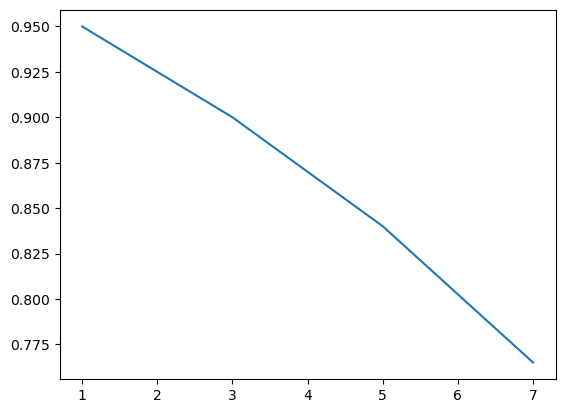

In [96]:
plt.plot(k_neighbors,np.array(accuracies))
plt.show()

In [9]:
class LDA:
    def __init__(self,train_data,labels,n_components=39):
        self.X = train_data
        self.labels = labels
        self.n_components = n_components
        self.trained = False 
        
    def update_n_components(self,n):
        if self.trained == True:
            self.n_components = n
            self.U = self.eigen_vectors[:,:self.n_components+1]   
            self.A = self.X.dot(self.U)
        
    
    def fit(self):
        n_features = self.X.shape[1]
        # between class scatter matrix
        Sb = np.zeros((n_features,n_features))
        S = np.zeros((n_features,n_features))
        total_mu = np.mean(self.X,axis=0)
        classes = np.unique(self.labels)
        for label in classes:
            X_k = self.X[self.labels==label]
            mu_k = np.mean(X_k,axis=0)
            n_k = X_k.shape[0]
            xx = (mu_k - total_mu).reshape(-1,1)
            # Sb += n_k * (xx.dot(xx.T))
            Sb += n_k * np.dot(xx,xx.T)
            Z_k = X_k - mu_k.reshape(-1,1).T
            S_k = Z_k.T @ Z_k
            S += S_k
        temp = np.dot(np.linalg.inv(S),Sb)
        x,y = np.linalg.eigh(temp)
        idx = x.argsort()[::-1]   
        self.eigen_values = x[idx]
        eigen_vectors = y[:,idx]
        self.eigen_vectors = np.array(eigen_vectors)
        self.U = self.eigen_vectors[:,:self.n_components+1]   
        self.A = self.X.dot(self.U)
        self.trained = True
        
    def transform(self,X_new):
        return X_new.dot(self.U)


In [9]:
lda=LDA(X_train,y_train)
lda.fit()

In [12]:
lda.update_n_components(60)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ldaa = LinearDiscriminantAnalysis(n_components=39)
ldaa.fit(X_train,y_train)
y_pred = ldaa.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.945


In [12]:
k_neighbors = np.arange(1,8,2)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNN(n_neighbors=k)
    knn.fit(lda.A,y_train)
    y_pred = knn.predict((lda.transform(X_test)))
    accuracies.append(accuracy_score(y_pred,y_test))
    print(f"k = {k}\taverage accuracy = {accuracies[i]*100}%")

k = 1	average accuracy = 94.5%
k = 3	average accuracy = 88.5%
k = 5	average accuracy = 83.0%
k = 7	average accuracy = 80.0%


In [222]:
import os

def load_non_faces(folder):
    images = []
    labels = []
    img_resized = np.zeros((1,10304))
    for file in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,file),0)
        img_resized =cv2.resize(img, (92,112))
        images.append(img_resized.flatten())
        labels.append(0)
    return np.array(images),np.array(labels)

In [223]:
images,labels_non = load_non_faces("./non_faces")

In [224]:
print(labels_non.shape)
print(images.shape)

(400,)
(400, 10304)


In [225]:
np.random.shuffle(images)
dataset = np.append(X,images,axis=0)


In [226]:
labels_faces = np.ones([400,1])
data_labels = np.append(labels_faces,labels_non)
data_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [227]:
X_train_new, y_train_new, X_test_new, y_test_new = train_test_split(dataset,data_labels)

In [228]:
pca = PCA(X_train_new,0.80)
pca.train()

Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 38 eigen values reach (0.8011940922631124+4.47046280138082e-33j) variance.


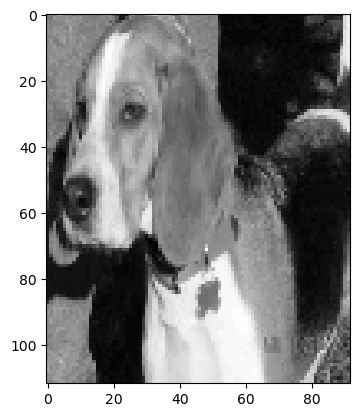

In [230]:
img = np.reshape(X_train_new[209],(112,92))
plt.imshow(img, cmap='gray')
plt.show()

In [231]:
k_neighbors = np.arange(1,8,2)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca.A.real,y_train_new)
    y_pred = knn.predict((pca.transform(X_test_new).real))
    accuracies.append(accuracy_score(y_pred,y_test_new))
    print(f"k = {k}\taverage accuracy = {accuracies[i]*100}%")

k = 1	average accuracy = 92.0%
k = 3	average accuracy = 90.25%
k = 5	average accuracy = 88.0%
k = 7	average accuracy = 87.25%


In [232]:
k_neighbors = np.arange(1,8,2)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNN(n_neighbors=k)
    knn.fit(pca.A,y_train_new)
    y_pred = knn.predict((pca.transform(X_test_new)))
    accuracies.append(accuracy_score(y_pred,y_test_new))
    print(f"k = {k}\taverage accuracy = {accuracies[i]*100}%")

k = 1	average accuracy = 92.0%
k = 3	average accuracy = 90.25%
k = 5	average accuracy = 88.0%
k = 7	average accuracy = 87.25%


In [247]:
pca.update_alpha(0.7)

Finding top n eigen values to reach alpha (0.7): .. Done. -- Found top 17 eigen values reach (0.7046059097221744+3.931524882002799e-33j) variance.


In [248]:
k_neighbors = np.arange(1,8,2)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNN(n_neighbors=k)
    knn.fit(pca.A,y_train_new)
    y_pred = knn.predict((pca.transform(X_test_new)))
    accuracies.append(accuracy_score(y_pred,y_test_new))
    print(f"k = {k}\taverage accuracy = {accuracies[i]*100}%")

k = 1	average accuracy = 94.25%
k = 3	average accuracy = 91.75%
k = 5	average accuracy = 90.75%
k = 7	average accuracy = 89.5%
